# **Staff Attrition**
## **Decision Tree and Random Forest**

---

Problems
Buatlah model machine learning untuk mengklasifikasikan kemungkinan attrition karyawan. Bandingkan antara model Decision Tree dan Random Forest. Analisa dua buah model ini dan tentukan model yang terbaik untuk data ini ! Dataset URL

    1. Berapa % Attrition pada dataset tersebut?
    2. Umur berapa yang memiliki attration tertinggi?
    3. Apakah performance dan job satisfaction mempengaruhi attrition?
    4. Apakah yang memeliki income yang rendah, lebih cenderung Attrition?
    5. Apakah work life balance mempengaruhi tingkat attrition?
    
Note: Untuk soal nomor 2-6, kerjakan dibagian EDA (buat visualisasi dan analisanya).

## Import Pustaka
---

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

import pickle
import ast

Mengimpor semua pustaka yang digunakan pada analisis ini.

## Data Loading
---

In [79]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Load data dan menyimpan ke dalam variabel df

----
## EDA

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Data bertipe int dan object saja dan terlihat tidak ada nilai Null

2. Berapa % Attrition pada dataset tersebut?

In [81]:
age = df.groupby('Attrition')['Attrition'].value_counts()
age

Attrition  Attrition
No         No           1233
Yes        Yes           237
Name: Attrition, dtype: int64

Filtering data berdasarkan attrition dan menghitung jumlah datanya

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attrition', ylabel='count'>

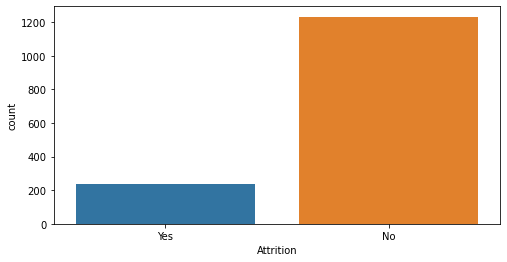

In [82]:
plt.figure(figsize=(8,4))
sns.countplot(df['Attrition'])

Ploting untuk visualisasi jumlah tiap attrition

In [83]:
print(237/1470*100, '%')

16.122448979591837 %


> Attrition pada dataset ini sebesar **16.12 %**

In [84]:
tes1 = df.query("Attrition == 'Yes'")
tes_age = pd.DataFrame(tes1['Age'].value_counts().sort_index(ascending=True))
tes_age['count']=tes_age['Age']
tes_age['Age']=tes_age.index
tes_age.head()

,Age,count
18,18,4
19,19,6
20,20,6
21,21,6
22,22,5


Query untuk filtering data Attrition==Yes berdasarkan umur

In [85]:
tes_age.reset_index(inplace=True,drop=True)
tes_age.max()

Age      58
count    18
dtype: int64

Hasil filtering data umur dan attrition

<AxesSubplot:xlabel='Age', ylabel='count'>

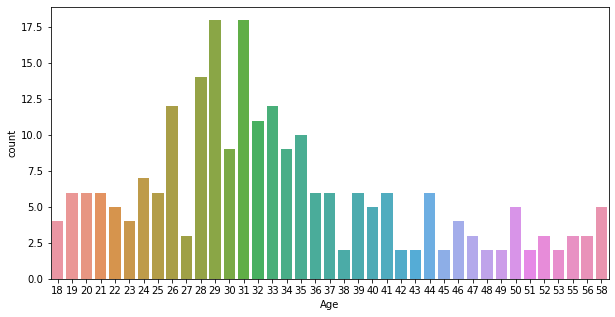

In [86]:
plt.figure(figsize=(10,5))
sns.barplot(data=tes_age,x='Age',y='count')

Berdasarkan kode max dan visualisasi barplot bisa dilihat untuk attrition tertinggi ada pada umur 29 dan 31 dengan jumlah 18 orang.
Untuk umur tertua yang attrition ada di umur 58.

### Nomor 4
> Apakah performance dan job satisfaction mempengaruhi attrition?

In [87]:
persat = df[['PerformanceRating','JobSatisfaction','Attrition']]
persat2 = persat.groupby('Attrition')['PerformanceRating'].value_counts(sort=False)
persat3 = persat.groupby('Attrition')['JobSatisfaction'].value_counts(sort=False)

Filtering dan grouping data untuk 'PerformanceRating','JobSatisfaction','Attrition'

Text(0.5, 1.0, 'JobSatisfaction')

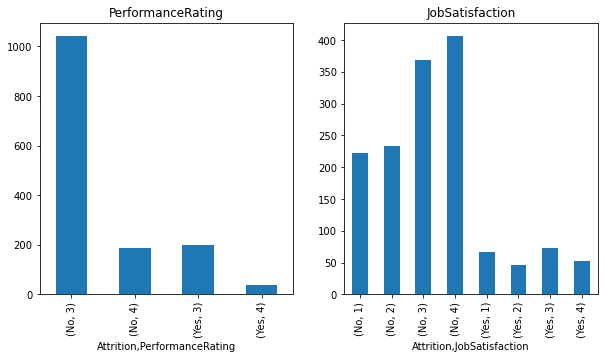

In [88]:
fig = plt.figure(figsize=(10,5))
row = 1
col = 2

# figure, axis = plt.subplots(2,2)
fig.add_subplot(row, col, 1)
persat2.plot(kind='bar')
plt.title('PerformanceRating')

fig.add_subplot(row, col, 2)
persat3.plot(kind='bar')
plt.title('JobSatisfaction')

Ploting data hasil filtering untuk mempermudah analisa

> Berdasarkan performance rating hanya ada 3 Excellent dan 4 Outstanding, jika ada yang attrition berdasarkan performance memang yang lebih banyak walaupun secara keseluruhan dengan performance sebagus itu tidak attrition

> untuk Job Satisfaction terlihat makin setinggi angkanya semakin tidak attrition, untuk yg attrition jauh lebih sedikit jumlahnya, walaupun ketika angka 3 High cenderung lebih banyak yg attrition dibanding yg lain. Diasumsikan job satifaction cukup berpengaruh terhadap attrition

### Nomor 5


In [89]:
income = df[['MonthlyIncome','Attrition']]
income = income.sort_values(by='MonthlyIncome')
income.reset_index(drop=True, inplace=True)

<AxesSubplot:ylabel='MonthlyIncome'>

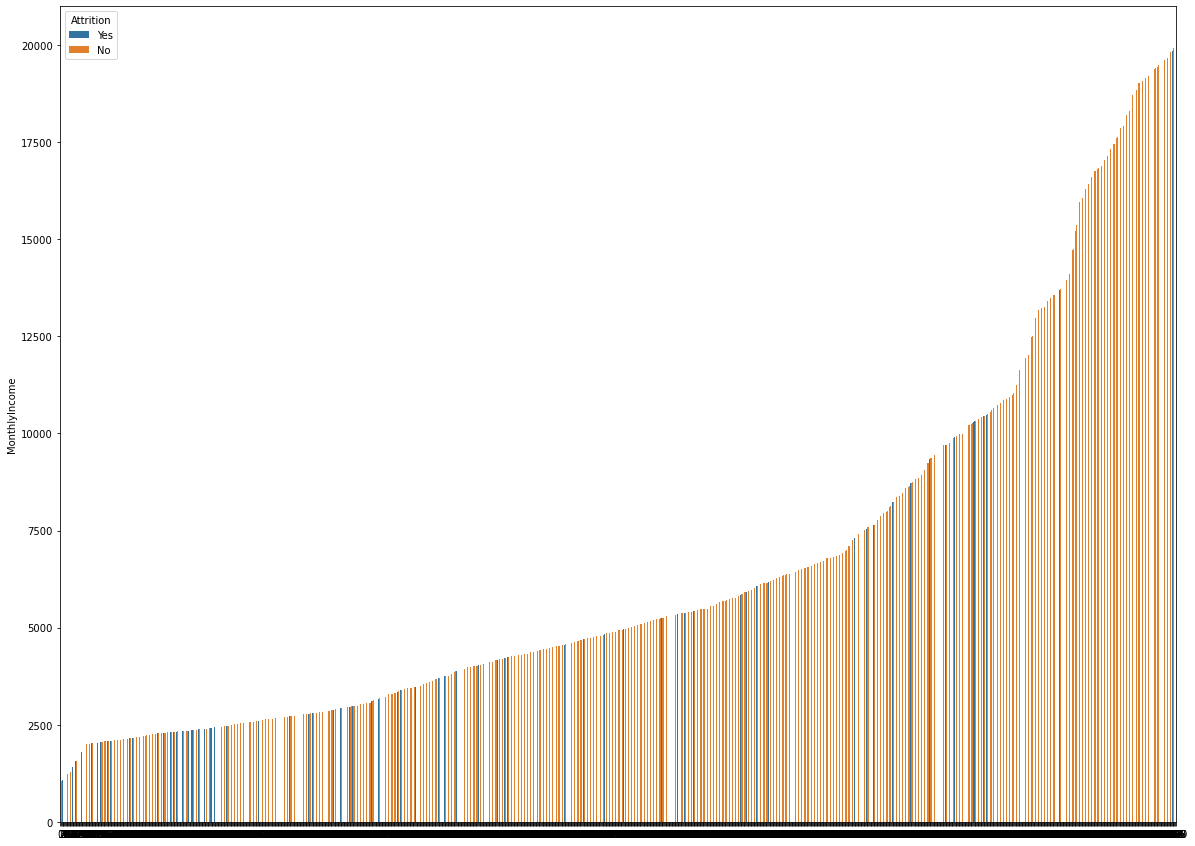

In [90]:
plt.figure(figsize=(20,15))
sns.barplot(data=income,x=income.index,y=income['MonthlyIncome'],hue=income['Attrition'])

Berdasarkan hasil barplot terlihat memang ketika gaji lebih rendah lebih banyak terjadi attrition

### Nomor 6

Apakah work life balance mempengaruhi tingkat attrition?

<AxesSubplot:xlabel='Attrition,WorkLifeBalance'>

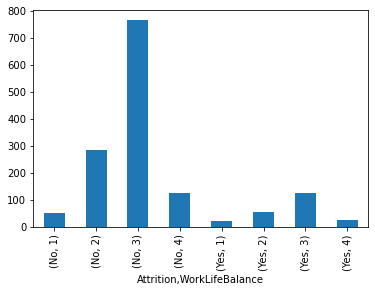

In [91]:
worklifebal = df.groupby('Attrition')['WorkLifeBalance'].value_counts(sort=False)
# worklifebal
worklifebal.plot(kind='bar')

Berdasarkan barplot worklife balance berpengaruh sampai di kategori 3 (Good) semakin better maka semakin tidak Attrition, walaupun cukup janggal ketika Best (4) malah turun jumlah attritionnya.

----
## Data Preprocessing

### a. Inference

In [92]:
# get data for model inference
df_inf = df.sample(10, random_state=28)
df_inf

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
548,43,No,Travel_Frequently,775,Sales,15,3,Life Sciences,1,754,...,3,80,1,7,5,3,2,2,2,2
1149,27,No,Travel_Rarely,1302,Research & Development,19,3,Other,1,1619,...,1,80,2,7,3,3,7,7,0,7
1346,45,No,Travel_Rarely,556,Research & Development,25,2,Life Sciences,1,1888,...,4,80,2,10,2,2,9,8,3,8
1158,37,No,Travel_Rarely,671,Research & Development,19,3,Life Sciences,1,1631,...,1,80,3,9,2,2,4,3,0,2
246,33,No,Travel_Rarely,832,Research & Development,5,4,Life Sciences,1,338,...,3,80,1,2,2,2,2,2,0,2
446,41,No,Non-Travel,267,Sales,10,2,Life Sciences,1,599,...,4,80,0,16,3,3,14,3,1,10
403,41,No,Travel_Rarely,645,Sales,1,3,Marketing,1,534,...,3,80,1,10,2,3,10,7,0,7
1397,54,No,Travel_Rarely,155,Research & Development,9,2,Life Sciences,1,1969,...,3,80,2,9,6,2,4,3,2,3
1061,24,No,Non-Travel,830,Sales,13,2,Life Sciences,1,1495,...,3,80,1,1,2,3,1,0,0,0
1132,40,No,Travel_Rarely,118,Sales,14,2,Life Sciences,1,1598,...,3,80,1,5,2,3,5,4,1,2


Mengambil 10 data inference untuk nantinya diuji coba terhadap model yang sudah dibuat.

In [93]:
df_train_test = df.drop(df_inf.index)
df_train_test

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


Data yang telah dipisahkan dari 10 data inference disimpan dalam variabel df_train_test

In [94]:
# reset index
df_train_test.reset_index(drop=True, inplace=True)
df_inf.reset_index(drop=True, inplace=True)
df_inf

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,43,No,Travel_Frequently,775,Sales,15,3,Life Sciences,1,754,...,3,80,1,7,5,3,2,2,2,2
1,27,No,Travel_Rarely,1302,Research & Development,19,3,Other,1,1619,...,1,80,2,7,3,3,7,7,0,7
2,45,No,Travel_Rarely,556,Research & Development,25,2,Life Sciences,1,1888,...,4,80,2,10,2,2,9,8,3,8
3,37,No,Travel_Rarely,671,Research & Development,19,3,Life Sciences,1,1631,...,1,80,3,9,2,2,4,3,0,2
4,33,No,Travel_Rarely,832,Research & Development,5,4,Life Sciences,1,338,...,3,80,1,2,2,2,2,2,0,2
5,41,No,Non-Travel,267,Sales,10,2,Life Sciences,1,599,...,4,80,0,16,3,3,14,3,1,10
6,41,No,Travel_Rarely,645,Sales,1,3,Marketing,1,534,...,3,80,1,10,2,3,10,7,0,7
7,54,No,Travel_Rarely,155,Research & Development,9,2,Life Sciences,1,1969,...,3,80,2,9,6,2,4,3,2,3
8,24,No,Non-Travel,830,Sales,13,2,Life Sciences,1,1495,...,3,80,1,1,2,3,1,0,0,0
9,40,No,Travel_Rarely,118,Sales,14,2,Life Sciences,1,1598,...,3,80,1,5,2,3,5,4,1,2


### b. Splitting Data

In [95]:
# Split between `X` (Features) and `y` (Target)
X = df_train_test.drop('Attrition',axis=1)
y = df_train_test['Attrition']
X

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,1,80,0,8,0,1,6,4,0,5
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,4,80,1,10,3,3,10,7,1,7
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,2,80,0,7,3,3,0,0,0,0
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,3,80,0,8,3,3,8,7,3,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,36,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,...,3,80,1,17,3,3,5,2,0,3
1456,39,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,...,1,80,1,9,5,3,7,7,1,7
1457,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,...,2,80,1,6,0,3,6,2,0,3
1458,49,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,...,4,80,0,17,3,2,9,6,0,8


Memisahkan data fitur dan target yang akan dimodelkan nanti

In [96]:
# Split between Train-Set and Test-Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

print('X_train Size =', X_train.shape)
print('X_test Size  =', X_test.shape)
print('y_train Size =', y_train.shape)
print('y_test Size  =', y_test.shape)

X_train Size = (1168, 34)
X_test Size  = (292, 34)
y_train Size = (1168,)
y_test Size  = (292,)


Splitting data X dan y ke Train-Test set, lalu diperiksa shapenya

### c. Handling Missing Values

In [97]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [98]:
# numerical_pipeline = Pipeline([
# ('imputer', SimpleImputer(strategy='mean')),
# ('scaler', MinMaxScaler())
# ])

# categorical_pipeline = Pipeline([
# ('imputer', SimpleImputer(strategy='most_frequent')),
# ('onehot', OneHotEncoder())
# ])

> Tidak ada missing values pada data, namun nanti ada proses imputasi agar tidak error dalam preprocessing

### d. Handling Outliers

Decision Tree dan Random Forest tidak sensitif terhadap outliers jadi tidak perlu Handling Outliers

### e. Feature Selection

In [99]:
# Get Numerical Columns and Categorical Columns

num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns :  ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical Columns :  ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


Memisahkan data berdasarkan kolom numerik dan kategorik

### f. Scaling

In [100]:
print('X_train skewness =\n',X_train.skew())
print('X_test skewness =\n',X_test.skew())

X_train skewness =
 Age                         0.408043
DailyRate                   0.013763
DistanceFromHome            0.952190
Education                  -0.276101
EmployeeCount               0.000000
EmployeeNumber              0.017167
EnvironmentSatisfaction    -0.301830
HourlyRate                 -0.023185
JobInvolvement             -0.517275
JobLevel                    0.977521
JobSatisfaction            -0.311898
MonthlyIncome               1.312025
MonthlyRate                -0.025634
NumCompaniesWorked          1.019971
PercentSalaryHike           0.794340
PerformanceRating           1.964798
RelationshipSatisfaction   -0.284946
StandardHours               0.000000
StockOptionLevel            0.984449
TotalWorkingYears           1.064386
TrainingTimesLastYear       0.549343
WorkLifeBalance            -0.529943
YearsAtCompany              1.696563
YearsInCurrentRole          0.905465
YearsSinceLastPromotion     1.892581
YearsWithCurrManager        0.823319
dtype: float64
X_t

C:\Users\DELL\AppData\Local\Temp/ipykernel_7972/3996075523.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('X_train skewness =\n',X_train.skew())
C:\Users\DELL\AppData\Local\Temp/ipykernel_7972/3996075523.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('X_test skewness =\n',X_test.skew())


Data cenderung skewed dengan variasi ada yang >0.5 dan <0.5 maka akan menggunakan MinMaxScaler

In [101]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),('scaler', MinMaxScaler())])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder())])

Penggunaan OneHotEncoder karena data categorical bersifat nominal

In [102]:
preprocessor =  ColumnTransformer([
    ('numeric', num_pipeline,['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction',
                              'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
                              'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
                              'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']),
    ('category', cat_pipeline,['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime'])
])

ColumnTransforemer untuk pengolahan berdasarkan kategori dalam pipeline

----
## Decision Tree

In [103]:
pipeline_dt = Pipeline([
    ('prep',preprocessor),
    ('dt',DecisionTreeClassifier())
])

Pembuatan pipeline tanpa hyperparameter tuning

In [104]:
pipeline_dt.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeCount',
                                                   'EmployeeNumber',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
  

proses fit dengan decision tree

In [105]:
parameter_dt= {
    'dt__max_depth': [10, 30, 100],
    'dt__min_samples_split': [5, 30, 100],
    'dt__min_samples_leaf' : [5, 20, 50],
    'dt__max_features': ['auto', 'log2'],
    'dt__criterion': ['gini','entropy']
}


In [106]:
# Hyperparameter Tuning
best_dt= GridSearchCV(pipeline_dt, parameter_dt, cv=3, n_jobs=-1, verbose=1)
best_dt

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'DailyRate',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'Employe

Hyperparameter tuning dengan menggunakan GridsearchCV

In [107]:
best_dt.fit(X_train,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'DailyRate',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'Employe

Fit ulang dengan model yang telah di hyperparameter tuning

In [108]:
print("Best parameters: {}".format(best_dt.best_params_))
print("Best cross-validation score: {:.2f}".format(best_dt.best_score_))

Best parameters: {'dt__criterion': 'gini', 'dt__max_depth': 100, 'dt__max_features': 'auto', 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 100}
Best cross-validation score: 0.84


Hyperparameter terbaik berdasarkan GridsearchCV yang telah dilakukan.

In [109]:
y_pred_dt_train = best_dt.predict(X_train)

In [110]:
y_pred_dt_test = best_dt.predict(X_test)

In [111]:
print('Classification Report (Data Train)')
print('-------------------------------------\n')
print(classification_report(y_train, y_pred_dt_train))

Classification Report (Data Train)
-------------------------------------

              precision    recall  f1-score   support

          No       0.84      0.99      0.91       974
         Yes       0.55      0.06      0.10       194

    accuracy                           0.84      1168
   macro avg       0.70      0.52      0.51      1168
weighted avg       0.79      0.84      0.78      1168



In [112]:
print('Classification Report (Data Test)')
print('-------------------------------------\n')
print(classification_report(y_test, y_pred_dt_test))

Classification Report (Data Test)
-------------------------------------

              precision    recall  f1-score   support

          No       0.85      0.99      0.92       249
         Yes       0.33      0.02      0.04        43

    accuracy                           0.85       292
   macro avg       0.59      0.51      0.48       292
weighted avg       0.78      0.85      0.79       292



----
## Random Forest

In [113]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [114]:
pipeline_rf = Pipeline([
    ('prep',preprocessor),
    ('rf',RandomForestClassifier())
])

In [115]:
pipeline_rf.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeCount',
                                                   'EmployeeNumber',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
  

In [116]:
parameter_rf= {
    'rf__max_depth': [10, 25, 100],
    'rf__min_samples_split': [5, 10],
    'rf__min_samples_leaf' : [5, 10],
    'rf__max_leaf_nodes' : [10, 20],
    'rf__n_estimators': [25, 50, 100]
}

In [117]:
# dt__max_depth': [10, 25, 100],
#     'dt__min_samples_split': [10, 25, 50],
#     'dt__min_samples_leaf' : [5, 20, 50],
#     'dt__max_features': ['auto', 'log2']

In [118]:
best_rf = GridSearchCV(pipeline_rf, parameter_rf, cv=3, n_jobs=-1, verbose=1)


In [119]:
best_rf.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'DailyRate',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'Employe

In [120]:
best_rf.best_params_

{'rf__max_depth': 10,
 'rf__max_leaf_nodes': 20,
 'rf__min_samples_leaf': 5,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 50}

In [121]:
best_rf.score(X_train,y_train),pipeline_rf.score(X_test,y_test)

(0.8672945205479452, 0.863013698630137)

In [122]:
y_pred_rf_train = best_rf.predict(X_train)

In [123]:
y_pred_rf_test = best_rf.predict(X_test)

In [124]:
print('Classification Report (Data Train)')
print('---------------------------------------------\n')
print(classification_report(y_train, y_pred_rf_train))

Classification Report (Data Train)
---------------------------------------------

              precision    recall  f1-score   support

          No       0.86      1.00      0.93       974
         Yes       0.93      0.22      0.35       194

    accuracy                           0.87      1168
   macro avg       0.90      0.61      0.64      1168
weighted avg       0.88      0.87      0.83      1168



In [125]:
print('Classification Report (Data Test)')
print('---------------------------------------------\n')
print(classification_report(y_test, y_pred_rf_test))

Classification Report (Data Test)
---------------------------------------------

              precision    recall  f1-score   support

          No       0.86      0.99      0.92       249
         Yes       0.60      0.07      0.12        43

    accuracy                           0.86       292
   macro avg       0.73      0.53      0.52       292
weighted avg       0.82      0.86      0.80       292



----
## Model Evaluation

In [126]:
print('Decision Tree Accuracy Score Train :', accuracy_score(y_train, y_pred_dt_train))
print('Decision Tree Accuracy Score Test :', accuracy_score(y_test, y_pred_dt_test))
print('')
print('Random Forest Accuracy Score Train :', accuracy_score(y_train, y_pred_rf_train))
print('Random Forest Score Test :', accuracy_score(y_test, y_pred_rf_test))

Decision Tree Accuracy Score Train : 0.8356164383561644
Decision Tree Accuracy Score Test : 0.8493150684931506

Random Forest Accuracy Score Train : 0.8672945205479452
Random Forest Score Test : 0.8561643835616438


----
## Model Saving

In [127]:
# Model Saving

with open('pipeline_dt.pkl', 'wb') as file_1:
  pickle.dump(pipeline_dt, file_1)

with open('best_dt.pkl', 'wb') as file_2:
  pickle.dump(best_dt, file_2)

with open('pipeline_rf.pkl', 'wb') as file_3:
  pickle.dump(pipeline_rf, file_3)

with open('best_rf.pkl', 'wb') as file_4:
  pickle.dump(best_rf, file_4)

with open('list_num_columns.txt', 'w') as file_5:
  file_5.write(str(num_columns))

with open('list_cat_columns.txt', 'w') as file_6:
  file_6.write(str(cat_columns))

----

## Model Inference

In [128]:
# Load All Files

with open('pipeline_dt.pkl', 'rb') as file_1:
  pipeline_dt = pickle.load(file_1)

with open('best_dt.pkl', 'rb') as file_2:
  best_dt = pickle.load(file_2)

with open('pipeline_rf.pkl', 'rb') as file_3:
  pipeline_rf = pickle.load(file_3)

with open('best_rf.pkl', 'rb') as file_4:
  best_rf = pickle.load(file_4)
  
with open('list_num_columns.txt', 'r') as file_5:
  list_num_columns = file_5.read()

with open('list_cat_columns.txt', 'r') as file_6:
  list_cat_columns = file_6.read()



Load model yang telah dibuat.

In [129]:
# Convert `num_columns` and `cat_columns` into List

list_num_columns = ast.literal_eval(list_num_columns)
list_cat_columns = ast.literal_eval(list_cat_columns)
list_num_columns

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

### Inferencing

In [130]:
# Split between Numerical Columns and Categorical Columns

df_inf_num = df_inf[list_num_columns]
df_inf_cat = df_inf[list_cat_columns]

df_inf_num

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,43,775,15,3,1,754,4,47,2,2,...,3,80,1,7,5,3,2,2,2,2
1,27,1302,19,3,1,1619,4,67,2,1,...,1,80,2,7,3,3,7,7,0,7
2,45,556,25,2,1,1888,2,93,2,2,...,4,80,2,10,2,2,9,8,3,8
3,37,671,19,3,1,1631,3,85,3,2,...,1,80,3,9,2,2,4,3,0,2
4,33,832,5,4,1,338,3,63,2,1,...,3,80,1,2,2,2,2,2,0,2
5,41,267,10,2,1,599,4,56,3,2,...,4,80,0,16,3,3,14,3,1,10
6,41,645,1,3,1,534,2,49,4,3,...,3,80,1,10,2,3,10,7,0,7
7,54,155,9,2,1,1969,1,67,3,2,...,3,80,2,9,6,2,4,3,2,3
8,24,830,13,2,1,1495,4,78,3,1,...,3,80,1,1,2,3,1,0,0,0
9,40,118,14,2,1,1598,4,84,3,2,...,3,80,1,5,2,3,5,4,1,2


In [131]:
# Predict Inference-Set

y_pred_inf_dt = best_dt.predict(df_inf)
y_pred_inf_dt

array(['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No'],
      dtype=object)

Menggunakan model Decision Tree, dilakukan Attrition prediction dari df_inf tadi.

In [132]:
# Convert into DataFrame

y_pred_inf_dt_df = pd.DataFrame(y_pred_inf_dt, columns=['Attrition Prediction'])
y_pred_inf_dt_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Attrition Prediction  10 non-null     object
dtypes: object(1)
memory usage: 208.0+ bytes


Berikut hasil prediksi berdasarkan model yang telah dibuat.

In [133]:
# Merge Inference-Set and Prediction

pd.concat([df_inf, y_pred_inf_dt_df], axis=1)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition Prediction
0,43,No,Travel_Frequently,775,Sales,15,3,Life Sciences,1,754,...,80,1,7,5,3,2,2,2,2,No
1,27,No,Travel_Rarely,1302,Research & Development,19,3,Other,1,1619,...,80,2,7,3,3,7,7,0,7,No
2,45,No,Travel_Rarely,556,Research & Development,25,2,Life Sciences,1,1888,...,80,2,10,2,2,9,8,3,8,No
3,37,No,Travel_Rarely,671,Research & Development,19,3,Life Sciences,1,1631,...,80,3,9,2,2,4,3,0,2,No
4,33,No,Travel_Rarely,832,Research & Development,5,4,Life Sciences,1,338,...,80,1,2,2,2,2,2,0,2,No
5,41,No,Non-Travel,267,Sales,10,2,Life Sciences,1,599,...,80,0,16,3,3,14,3,1,10,No
6,41,No,Travel_Rarely,645,Sales,1,3,Marketing,1,534,...,80,1,10,2,3,10,7,0,7,No
7,54,No,Travel_Rarely,155,Research & Development,9,2,Life Sciences,1,1969,...,80,2,9,6,2,4,3,2,3,No
8,24,No,Non-Travel,830,Sales,13,2,Life Sciences,1,1495,...,80,1,1,2,3,1,0,0,0,No
9,40,No,Travel_Rarely,118,Sales,14,2,Life Sciences,1,1598,...,80,1,5,2,3,5,4,1,2,No


In [134]:
# Predict Inference-Set

y_pred_inf_rf = best_rf.predict(df_inf)
y_pred_inf_rf

array(['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No'],
      dtype=object)

Menggunakan model Random Forest, dilakukan Attrition prediction dari df_inf tadi.

In [135]:
# Convert into DataFrame

y_pred_inf_rf_df = pd.DataFrame(y_pred_inf_rf, columns=['Attrition Prediction'])
y_pred_inf_rf_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Attrition Prediction  10 non-null     object
dtypes: object(1)
memory usage: 208.0+ bytes


Berikut hasil prediksi berdasarkan model yang telah dibuat.

In [136]:
# Merge Inference-Set and Prediction

pd.concat([df_inf, y_pred_inf_rf_df], axis=1)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition Prediction
0,43,No,Travel_Frequently,775,Sales,15,3,Life Sciences,1,754,...,80,1,7,5,3,2,2,2,2,No
1,27,No,Travel_Rarely,1302,Research & Development,19,3,Other,1,1619,...,80,2,7,3,3,7,7,0,7,No
2,45,No,Travel_Rarely,556,Research & Development,25,2,Life Sciences,1,1888,...,80,2,10,2,2,9,8,3,8,No
3,37,No,Travel_Rarely,671,Research & Development,19,3,Life Sciences,1,1631,...,80,3,9,2,2,4,3,0,2,No
4,33,No,Travel_Rarely,832,Research & Development,5,4,Life Sciences,1,338,...,80,1,2,2,2,2,2,0,2,No
5,41,No,Non-Travel,267,Sales,10,2,Life Sciences,1,599,...,80,0,16,3,3,14,3,1,10,No
6,41,No,Travel_Rarely,645,Sales,1,3,Marketing,1,534,...,80,1,10,2,3,10,7,0,7,No
7,54,No,Travel_Rarely,155,Research & Development,9,2,Life Sciences,1,1969,...,80,2,9,6,2,4,3,2,3,No
8,24,No,Non-Travel,830,Sales,13,2,Life Sciences,1,1495,...,80,1,1,2,3,1,0,0,0,No
9,40,No,Travel_Rarely,118,Sales,14,2,Life Sciences,1,1598,...,80,1,5,2,3,5,4,1,2,No


----

## Kesimpulan

----

Decision Tree Accuracy Score Train : 0.851027397260274
Decision Tree Accuracy Score Test : 0.8595890410958904

Random Forest Accuracy Score Train : 0.8681506849315068
Random Forest Score Test : 0.8664383561643836


> Berdasarkan hasil accuracy kedua model diatas, diindikasikan tidak ada overfit atau underfit pada kedua model.

> Pada dataset ini model Random Forest memiliki akurasi lebih baik dengan menggunakan hyperparameter

    {'rf__max_depth': 100,
    'rf__max_leaf_nodes': 20,
    'rf__min_samples_leaf': 5,
    'rf__min_samples_split': 5,
    'rf__n_estimators': 100}